In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
#data = genfromtxt('file_3events.txt',delimiter=',')
data = genfromtxt('file_2events.txt',delimiter=',')
#data = genfromtxt('test_output_false_negative.txt', delimiter=',')
#data = genfromtxt('small_file.txt', delimiter=',')
data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
print(data)

[[ 0.          1.128016    0.913283   -2.69977     0.28471129]
 [ 1.          0.952915    0.519144    0.878809    1.        ]
 [ 1.          0.434082    0.56767    -2.311936    0.9832818 ]
 [ 2.          2.209619    1.105468    2.333682    0.55023501]
 [ 3.          1.71197     1.189179    1.119164    0.82337245]
 [ 3.          0.461599    0.777167   -0.144536    0.7915445 ]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.71810614]]


### reshape data

In [3]:
#print(np.min(data,axis=0)[0])
ll = []
true_vals = []
print(int(np.max(data,axis=0)[0]))
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    #print("This is mask:")
    #print(mask)
    evt = data[mask]
    #print(evt)
    #print(evt.shape[0])
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    for i, (idx1, idx2) in enumerate(pair_indices):
        l = []
        l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
        ll.append(l)
        if (evt[idx1,0] == evt[idx2,0]):
            true_vals.append(1)
        else:
            true_vals.append(0)
#print(ll)
input_data = torch.FloatTensor(ll)
input_data = torch.squeeze(input_data)
input_data.shape
truth_class = torch.FloatTensor(true_vals)
print(input_data.shape)
print(truth_class.shape)

5
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
torch.Size([12, 8])
torch.Size([12])


/tmp/ipykernel_71041/2613292932.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_data = torch.FloatTensor(ll)


### simple model

In [4]:
class feed_forward_model(nn.Module):
        def __init__(self,nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                #self.another_linear = torch.nn.Linear(100,100)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor


## final training

In [5]:
print(input_data.shape)
n_epochs = 1000
model = feed_forward_model(100)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.SGD(model.parameters(), lr=9e-4)
model.train()
loss_val = []
for epoch in range(n_epochs):
    y_pred = model(input_data)
    y_true = truth_class
    loss = loss_fn(y_pred,y_true)
    loss_val.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")

torch.Size([12, 8])
Finished epoch 0, latest loss 0.6530225276947021
Finished epoch 1, latest loss 0.6512738466262817
Finished epoch 2, latest loss 0.6495382189750671
Finished epoch 3, latest loss 0.6478155255317688
Finished epoch 4, latest loss 0.6461056470870972
Finished epoch 5, latest loss 0.6444084644317627
Finished epoch 6, latest loss 0.6427239775657654
Finished epoch 7, latest loss 0.641051709651947
Finished epoch 8, latest loss 0.6393921375274658
Finished epoch 9, latest loss 0.637744665145874
Finished epoch 10, latest loss 0.6361094117164612
Finished epoch 11, latest loss 0.6344861388206482
Finished epoch 12, latest loss 0.6328749656677246
Finished epoch 13, latest loss 0.6312756538391113
Finished epoch 14, latest loss 0.6296880841255188
Finished epoch 15, latest loss 0.6281121969223022
Finished epoch 16, latest loss 0.6265479326248169
Finished epoch 17, latest loss 0.6249950528144836
Finished epoch 18, latest loss 0.6234536170959473
Finished epoch 19, latest loss 0.621923506

Text(0, 0.5, 'loss value')

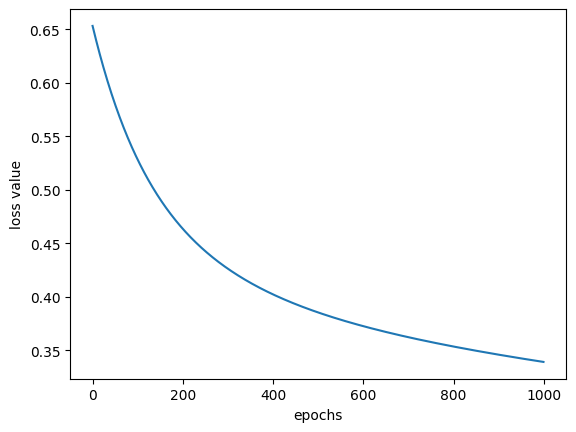

In [6]:
plt.plot(loss_val)
plt.xlabel("epochs")
plt.ylabel("loss value")

### look at pred. value distributions

In [7]:
#ff_model = feed_forward_model()
with torch.no_grad():
    model = torch.load("ff_scripted.pt")
    model.eval()
    
eval_pred = model(input_data).detach().numpy()   
eval_true = truth_class.detach().numpy()




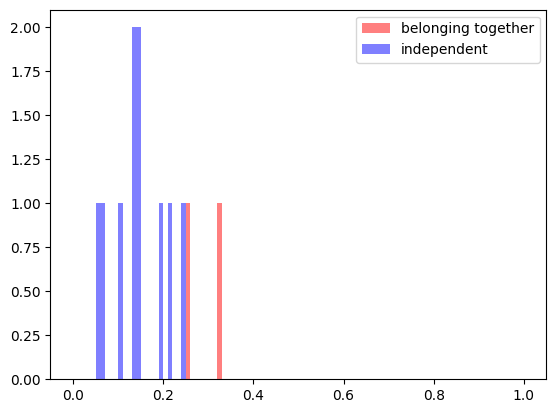

In [8]:
plt.hist(eval_pred[eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(eval_pred[eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.legend()

In [9]:
      
def run_lr(min_val,max_val,stepsize):
    #assert min_val.isdigit(), f"number is not integer, got: {type(min_val)}"
    #assert max_val.isdigit(), f"number is not integer, got: {type(max_val)}"
    #assert stepsize.isdigit(), f"number is not integer, got: {type(stepsize)}"
    n_epochs = 1000
    model = feed_forward_model(1000)
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_step_vals =[]
    for i in range(stepsize):
            lr_i = ((max_val - min_val)/stepsize)*i+min_val 
            optimizer = optim.SGD(model.parameters(), lr=lr_i)
            model.train()
            loss_val = []
            for epoch in range(n_epochs):
                y_pred = model(input_data)
                y_true = truth_class
                loss = loss_fn(y_pred,y_true)
                loss_val.append(loss.detach().item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_step_vals.append(loss_val)
    return loss_step_vals
    
    
    
    

def run_out_features(min_val,max_val,stepsize):
    n_epochs = 10000                                             ##set default n_epochs = 1000
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_step_vals =[]
    for i in range(stepsize):
            features = ((max_val - min_val)/stepsize)*i+min_val
            print("these are the features...",int(features))
            model = feed_forward_model(int(features))
            #optimizer = optim.SGD(model.parameters(), lr=9e-3)  ##set default lr
            optimizer = optim.SGD(model.parameters(), lr=5e-2)
            model.train()
            loss_val = []
            for epoch in range(n_epochs):
                y_pred = model(input_data)
                y_true = truth_class
                loss = loss_fn(y_pred,y_true)
                loss_val.append(loss.detach().item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_step_vals.append(loss_val)
    return loss_step_vals
    
def run_model(features,learning_rate):
    n_epochs = 10000
    model = feed_forward_model(features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        #print(input_data)
        #print(input_data.shape)
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]



In [10]:
### TODO uncomment again
# min_val = 1e-5
# max_val = 9e-1
# stepsize = 20

# test = run_lr(min_val,max_val,stepsize)

In [11]:
### TODO uncomment again

# lable_targets = [((max_val - min_val)/stepsize)*i+min_val for i in range(stepsize)]
# formatted_labels = [f'{label:.2e}' for label in lable_targets]

# plt.figure(figsize=(8, 6))

# for y,label in zip(test,formatted_labels):
#     plt.plot(y,label="lr ="+label)
    

# plt.xlabel("Epochs")
# plt.ylabel("Loss Value")
# plt.legend(loc='upper left')  # Add a legend to identify the lines
# plt.title("Loss Value Evolution for Specific Loss Rates")
# plt.grid(True)
# plt.savefig("learning_rate_vs_loss.png")

---
###  test by hand models

In [12]:
test_foo, foo_loss = run_model(18,8e-3)
print(foo_loss)

0.007232015486806631


---

### add the prediction values for some of the plots

[4.9498476e-09 1.1503496e-08 3.1138412e-14 9.9960548e-01 7.3119932e-05
 2.9337910e-12 9.9968195e-01 7.1071263e-06 4.6406745e-04 5.8465135e-09
 2.9696808e-05 2.1251126e-06]


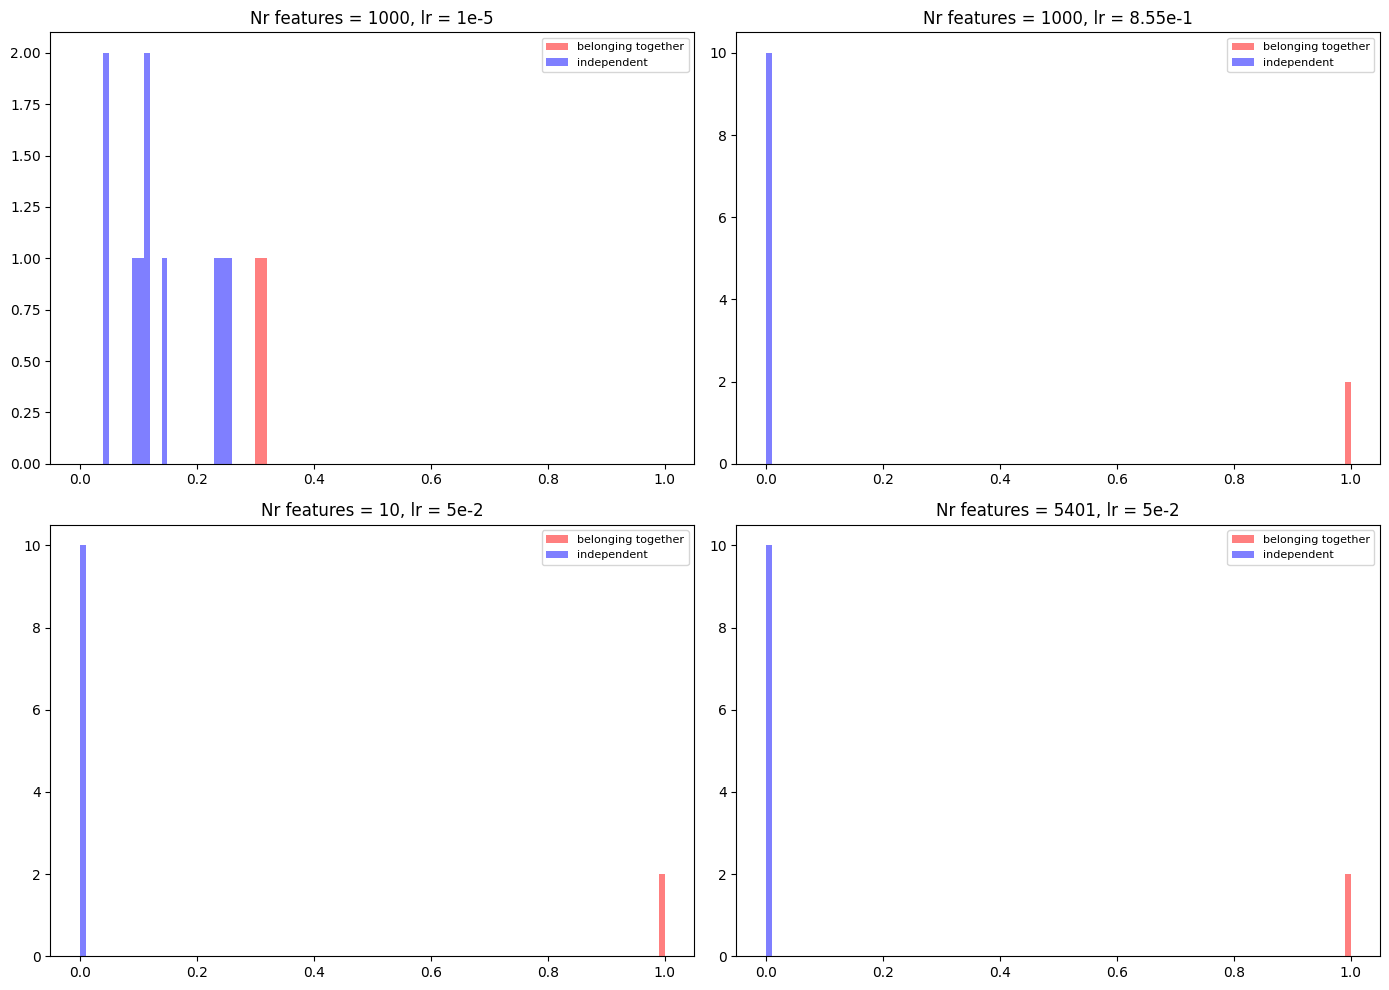

In [13]:
pred_lr_1_05 = run_model(1000,1e-5)
pred_lr_855_01 = run_model(1000,8.55e-1)

pred_features_10 = run_model(10,5e-2)
pred_features_5401 = run_model(5401,5e-2)

eval_true = truth_class.detach().numpy()

fig, axs = plt.subplots(2,2,figsize=(14,10))
fig.tight_layout()
axs[0,0].hist(pred_lr_1_05[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,0].hist(pred_lr_1_05[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,0].set_title("Nr features = 1000, lr = 1e-5",fontsize=12)
axs[0,0].legend(fontsize=8)
#axs[0,0].set_yscale("log")
axs[0,1].hist(pred_lr_855_01[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,1].hist(pred_lr_855_01[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,1].set_title("Nr features = 1000, lr = 8.55e-1",fontsize=12)
axs[0,1].legend(fontsize=8)
#axs[0,1].set_yscale("log")
axs[1,0].hist(pred_features_10[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,0].hist(pred_features_10[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,0].set_title("Nr features = 10, lr = 5e-2",fontsize=12)
axs[1,0].legend(fontsize=8)
#axs[1,0].set_yscale("log")
axs[1,1].hist(pred_features_5401[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,1].hist(pred_features_5401[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,1].set_title("Nr features = 5401, lr = 5e-2",fontsize=12)
axs[1,1].legend(fontsize=8)
#axs[1,1].set_yscale("log")
fig.tight_layout()

print(pred_features_5401[0])

### ok now look systematically at feature_nr evolution

In [14]:
min_val = 10
max_val = 6000
stepsize = 10
assert ((max_val-min_val) % stepsize == 0), "Wrong step size!"
test = run_out_features(min_val,max_val,stepsize)

these are the features... 10
these are the features... 609
these are the features... 1208
these are the features... 1807
these are the features... 2406
these are the features... 3005
these are the features... 3604
these are the features... 4203
these are the features... 4802
these are the features... 5401


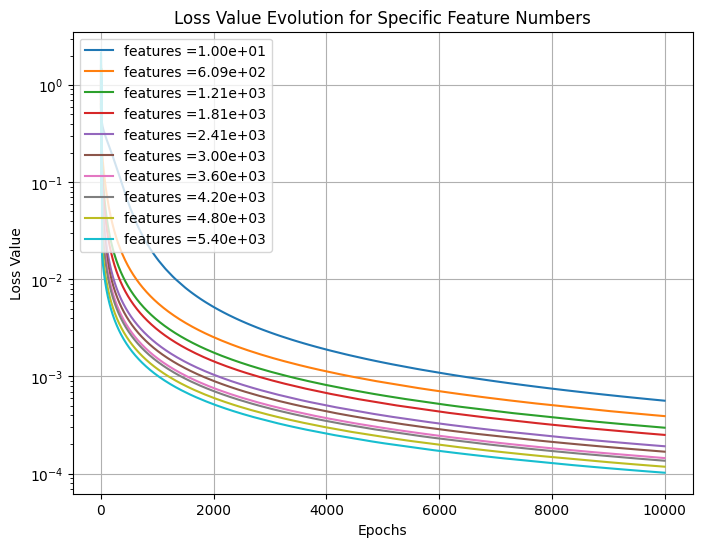

In [15]:
lable_targets = [((max_val - min_val)/stepsize)*i+min_val for i in range(stepsize)]
formatted_labels = [f'{label:.2e}' for label in lable_targets]

plt.figure(figsize=(8, 6))

for y,label in zip(test,formatted_labels):
    plt.plot(y,label="features ="+label)
    
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper left')  # Add a legend to identify the lines
plt.title("Loss Value Evolution for Specific Feature Numbers")
#plt.ylim(0, 0.2)
plt.grid(True)
plt.savefig("feature_size_vs_loss.png")

### make some plots indep/belonging together

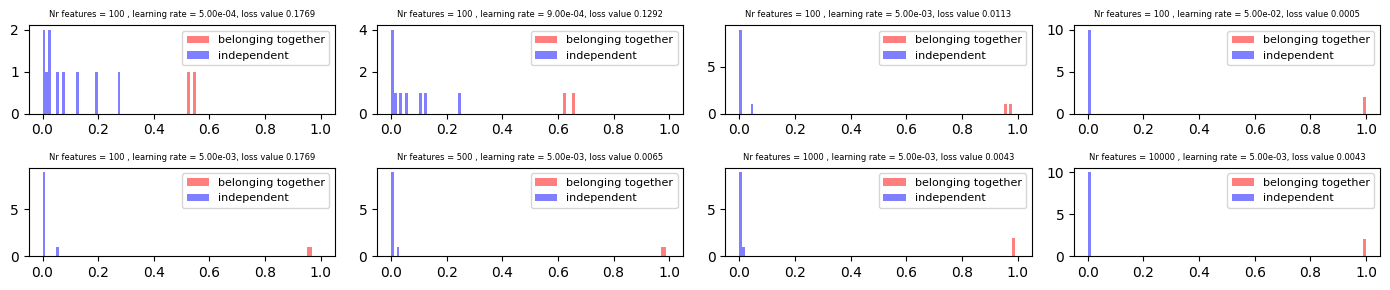

In [16]:

fig, axs = plt.subplots(2,4,figsize=(14,3))
fig.tight_layout()
##learning_rate variation
eval_pred_lr1 = run_model(100,5e-4)
eval_pred_lr2 = run_model(100,9e-4)
eval_pred_lr3 = run_model(100,5e-3)
eval_pred_lr4 = run_model(100,5e-2)
axs[0,0].hist(eval_pred_lr1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,0].hist(eval_pred_lr1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-4,eval_pred_lr1[1]),fontsize=6)
axs[0,0].legend(fontsize=8)

axs[0,1].hist(eval_pred_lr2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,1].hist(eval_pred_lr2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,9e-4,eval_pred_lr2[1]),fontsize=6)
axs[0,1].legend(fontsize=8)


axs[0,2].hist(eval_pred_lr3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,2].hist(eval_pred_lr3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-3,eval_pred_lr3[1]),fontsize=6)
axs[0,2].legend(fontsize=8)



axs[0,3].hist(eval_pred_lr4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0,3].hist(eval_pred_lr4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0,3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-2,eval_pred_lr4[1]),fontsize=6)
axs[0,3].legend(fontsize=8)

## feature size variation
eval_pred_ft1 = run_model(100,5e-3)
eval_pred_ft2 = run_model(500,5e-3)
eval_pred_ft3 = run_model(1000,5e-3)
eval_pred_ft4 = run_model(10000,5e-3)

axs[1,0].hist(eval_pred_ft1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,0].hist(eval_pred_ft1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (100,5e-3,eval_pred_lr1[1]),fontsize=6)
axs[1,0].legend(fontsize=8)

axs[1,1].hist(eval_pred_ft2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,1].hist(eval_pred_ft2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (500,5e-3,eval_pred_ft2[1]),fontsize=6)
axs[1,1].legend(fontsize=8)


axs[1,2].hist(eval_pred_ft3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,2].hist(eval_pred_ft3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (1000,5e-3,eval_pred_ft3[1]),fontsize=6)
axs[1,2].legend(fontsize=8)


axs[1,3].hist(eval_pred_ft4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1,3].hist(eval_pred_ft4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1,3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f" % (10000,5e-3,eval_pred_ft3[1]),fontsize=6)
axs[1,3].legend(fontsize=8)


fig.tight_layout()
plt.savefig("feature_size_and_lr_vs_loss.png")

### include now a second hidden layer (and maybe another one more...)

#### I would say to put in up to 5 hidden layers, with feature size = 256 or even a mixture

In [17]:
class hidden_layer_model(nn.Module):
        def __init__(self,nodes,hidden_nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                self.another_linear = torch.nn.Linear(nodes,hidden_nodes)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(hidden_nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.another_linear(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor

class two_hidden_layer_model(nn.Module):
        def __init__(self,nodes,hidden_nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                self.another_linear = torch.nn.Linear(nodes,hidden_nodes)
                self.another_linear_two = torch.nn.Linear(hidden_nodes,hidden_nodes)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(hidden_nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.another_linear(output_tensor)
                output_tensor = self.another_linear_two(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor
    

In [18]:
def run_hidden_model(features,learning_rate,hidden_features):
    n_epochs = 1000
    model = hidden_layer_model(features,hidden_features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]

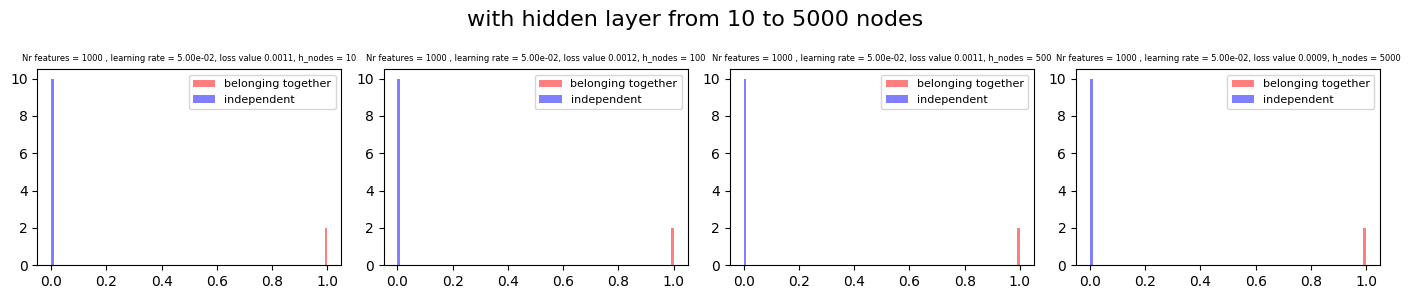

In [19]:

fig, axs = plt.subplots(1,4,figsize=(14,3))
fig.tight_layout()

##hidden layer nodes  variation
eval_pred_h1 = run_hidden_model(1000,5e-2,10)
eval_pred_h2 = run_hidden_model(1000,5e-2,100)
eval_pred_h3 = run_hidden_model(1000,5e-2,500)
eval_pred_h4 = run_hidden_model(1000,5e-2,5000)
axs[0].hist(eval_pred_h1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0].hist(eval_pred_h1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h1[1],10),fontsize=6)
axs[0].legend(fontsize=8)
axs[1].hist(eval_pred_h2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1].hist(eval_pred_h2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h2[1],100),fontsize=6)
axs[1].legend(fontsize=8)
axs[2].hist(eval_pred_h3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[2].hist(eval_pred_h3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h3[1],500),fontsize=6)
axs[2].legend(fontsize=8)
axs[3].hist(eval_pred_h4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[3].hist(eval_pred_h4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h4[1],5000),fontsize=6)
axs[3].legend(fontsize=8)
fig.suptitle('with hidden layer from 10 to 5000 nodes', fontsize=16)
fig.tight_layout()
plt.savefig("one_hidden_layer.png")





In [20]:
def run_two_hidden_model(features,learning_rate,hidden_features):
    n_epochs = 1000
    model = two_hidden_layer_model(features,hidden_features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]
    

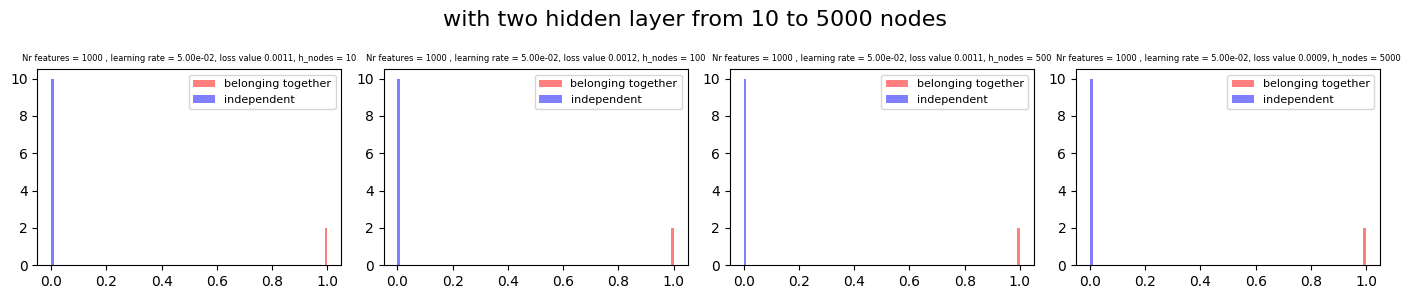

In [21]:
fig, axs = plt.subplots(1,4,figsize=(14,3))
fig.tight_layout()

##hidden layer nodes  variation
eval_pred_hh1 = run_two_hidden_model(1000,5e-2,10)
eval_pred_hh2 = run_two_hidden_model(1000,5e-2,100)
eval_pred_hh3 = run_two_hidden_model(1000,5e-2,500)
eval_pred_hh4 = run_two_hidden_model(1000,5e-2,5000)
axs[0].hist(eval_pred_hh1[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[0].hist(eval_pred_hh1[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[0].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h1[1],10),fontsize=6)
axs[0].legend(fontsize=8)
axs[1].hist(eval_pred_hh2[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[1].hist(eval_pred_hh2[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[1].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h2[1],100),fontsize=6)
axs[1].legend(fontsize=8)
axs[2].hist(eval_pred_hh3[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[2].hist(eval_pred_hh3[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[2].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h3[1],500),fontsize=6)
axs[2].legend(fontsize=8)
axs[3].hist(eval_pred_hh4[0][eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
axs[3].hist(eval_pred_hh4[0][eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
axs[3].set_title("Nr features = %.i , learning rate = %.2e, loss value %.4f, h_nodes = %.i" % (1000,5e-2,eval_pred_h4[1],5000),fontsize=6)
axs[3].legend(fontsize=8)
fig.suptitle('with two hidden layer from 10 to 5000 nodes', fontsize=16)
fig.tight_layout()
plt.savefig("two_hidden_layers.png")

## spectra plotting

6
1.128016
1.386997
2.209619
2.173569
2.029792
0.756178
(12,)
1.1462056e-06
[2.2028994e-06 1.1462056e-06 3.1014238e-10 9.9660683e-01 5.4859376e-04
 6.3358079e-09 9.9746704e-01 9.4058320e-05 3.8280785e-03 8.2382263e-07
 3.2642583e-04 8.2534541e-05]


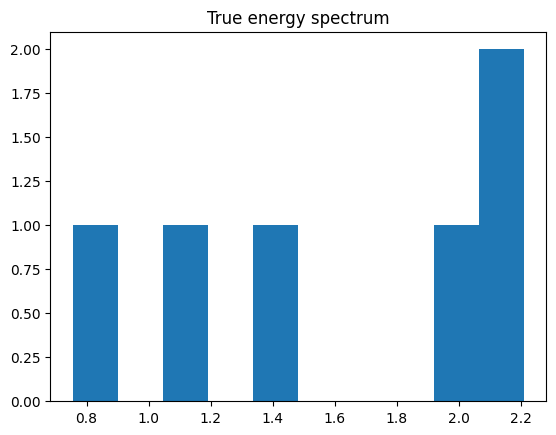

In [22]:
energy_spec = []
unique_ind = np.unique(data[:,0])
print(unique_ind.shape[0])
for i in range(unique_ind.shape[0]):
    ene = np.sum(data[data[:,0] == i,1])
    print (ene)
    energy_spec.append(ene)

plt.hist(energy_spec)
plt.title("True energy spectrum")

print(eval_pred_h4[0].shape)
print(eval_pred_h4[0][1])

print(eval_pred_h4[0])

[[ 0.          1.128016    0.913283   -2.69977     0.28471129]
 [ 1.          0.952915    0.519144    0.878809    1.        ]
 [ 1.          0.434082    0.56767    -2.311936    0.9832818 ]
 [ 2.          2.209619    1.105468    2.333682    0.55023501]
 [ 3.          1.71197     1.189179    1.119164    0.82337245]
 [ 3.          0.461599    0.777167   -0.144536    0.7915445 ]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.71810614]]
[[ 0.          1.128016    0.913283   -2.69977     0.28471129]
 [ 1.          0.952915    0.519144    0.878809    1.        ]
 [ 1.          0.434082    0.56767    -2.311936    0.9832818 ]
 [ 2.          2.209619    1.105468    2.333682    0.55023501]]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Connected components: [{0}, {1, 2}, {3}]
<class 'list'>
this is type of k:
1.128016
<class 'set'>
this is type of k:
1.386997
<class 'set'>
this is type of k:
2.209619
<class 's

Text(0.5, 1.0, 'Reconstructed energy spectrum')

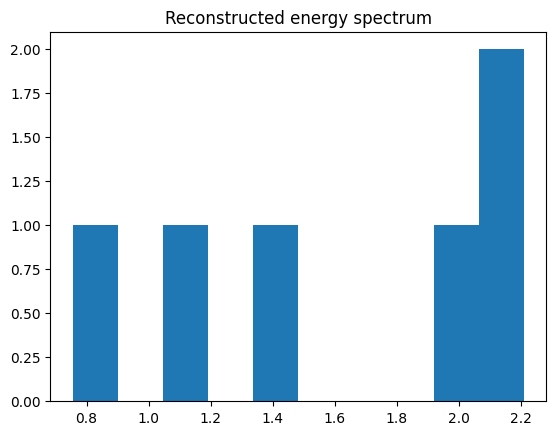

In [23]:
import networkx as nx
print(data)
ene_list = []
idx = 0
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    evt = data[mask]
    print(evt)
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    ##pair indices which belong together...
    pred_comb = []
    for m in range(evt.shape[0]):
        pred_comb.append((m,m))
    for j in range (len(pair_indices)):
        if eval_pred_h4[0][idx+j] > 0.5:
            pred_comb.append(pair_indices[j])
    G = nx.Graph()
    G.add_edges_from(pred_comb)
    connected_components = list(nx.connected_components(G))
    print("Connected components:", connected_components)
    print(type(connected_components))
    for k in range(len(connected_components)):
        print("this is type of k:")
        columns_to_sum = evt[list(connected_components[k]),1]
        ene = np.sum(columns_to_sum)
        ene_list.append(ene)
        print(ene)
        print(type(connected_components[k]))
    idx += len(pair_indices)


plt.hist(ene_list)
plt.title("Reconstructed energy spectrum")
    # for i, (idx1, idx2) in enumerate(pair_indices):
    #     l = []
    #     l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
    #     ll.append(l)
    #     if (evt[idx1,0] == evt[idx2,0]):
    #         true_vals.append(1)
    #     else:
    #         true_vals.append(0)